This is a widget-heavy notebook that uses the nomenclature in [1] to design airfoils and analyze them.
You can analyze the vast array of airfoils in [1] by simply pasting the code of the airfoil below. Or make your own airfoil design by using the sliders.

[1] Melin, T. (2013). *Parametric Airfoil Catalog: An Aerodynamic and Geometric Comparison Between Parametrized and Point Cloud Airfoils - Part 1 and 2*.

In [1]:
%%html
<style>
.ui-dialog-titlebar {
  display: none;
}
</style>

<IPython.core.display.Javascript object>


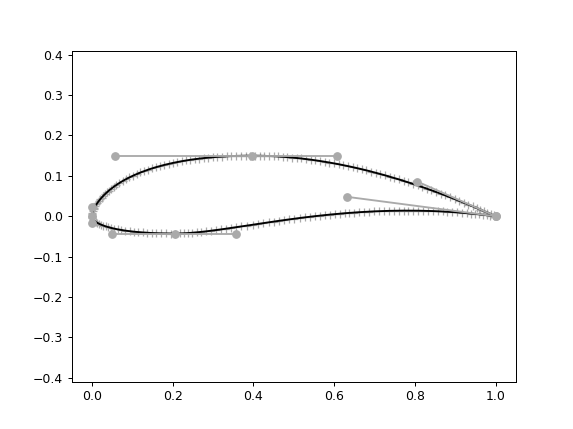

Output()

In [2]:
%matplotlib notebook
%config InlineBackend.figure_format = 'svg'
import logging
logging.getLogger().setLevel(logging.ERROR)

from af_ui import * 
import viiflowtools.vf_tools as vft

# Default to read. After running this cell this is loaded.
Airfoil = "K2ZW_awNMSkkS6I"
AirfoilName ="GOE222"

import IPython.display as ipydisp


AFCODE = widgets.Text(
    value = Airfoil,
    description='Airfoil Code',
    disabled=False
)

AFNAME = widgets.Text(
    value = AirfoilName,
    description='Airfoil Name',
    disabled=False
)

CODEBTN = widgets.Button(
    description='Load Code',
    disabled=False,
    button_style='warning', # 'success', 'info', 'warning', 'danger' or '',
    icon=''
)

def download_points(b):
    # Save discretized airfoil points, if you want
    global AirfoilName
    jsopenAF = """
    <script type="text/Javascript">
    window.open("Airfoil.dat");
    </script>
    """
    savePoints('Airfoil.dat',X,AirfoilName)
    display(ipydisp.HTML(jsopenAF));

DOWNPOINTS = widgets.Button(
    description='Download Points',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or '',
    icon='download'
)

DOWNPOINTS.on_click(download_points)

LOAD = widgets.HBox([AFNAME,AFCODE, CODEBTN,DOWNPOINTS])

# Import airfoil designer modules
# This includes numpy, matplotlib, ...

kparam = B64read(Airfoil)

# "global" variables, i.e. those that I want to use from within the widget-functions.
X = []
P = []

# k1 to k15 are the parameters as in [1]
ParNames = ["Nose Thck","Lead Point","Mid Point","Trail Point","Thickness",
           "Nose Thck","Lead Point","Mid Point","Trail Point","Thickness",
           "Top Len","Bottom Len","Angle Legs","Angle TE","Gap"]

# Create sliders
ks = []
for k in range(len(ParNames)):
    ks.append(FloatSlider(value = kparam[k], min=0, max=1, step=0.01, 
                          continuous_update=False,description=ParNames[k]))
    
def set_code(b):
    # Set Airfoil
    global ks, AFCODE
    kparam = B64read(AFCODE.value)
    print(AFCODE.value)
    for k in range(len(ks)):
        ks[k].value=kparam[k]

CODEBTN.on_click(set_code)
    
# Create Plot    
fig,ax = plt.subplots(1,1)

'''
# This shows an image one may want to approximate
A=np.sum(plt.imread('AFIMG.png'),2).astype(float)
m = 1.0*A.shape[0]
n = 1.0*A.shape[1]
#ax.imshow(A,extent=[0,1,-.1,.1])
ax.imshow(A,extent=[0,1,-m/n/2,m/n/2])
'''

handles = []

# Widget function
def manipulateAirfoil(k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,N,LEFAC,TEFAC,KAPFAC,
                      REFTOPX0,REFTOPX1,REFBOTX0,REFBOTX1,REFVAL):
    
    # Airfoil Coordinates
    global X,P,kparam,AirfoilName # Set of Bezier Points, Airfoil coordinates, melin Airfoil parameters
    global fig,ax,handles # figure, axis and plot handles
     

    for kp in range(15):
        kparam[kp] = eval("k%u"%(kp+1))
    P = foilPoints(kparam)
    ds = 0.0005
    (T,ArcPoints,Curvature) = pointsByArcLength(P,np.arange(0,1+ds,ds))
    (S,_,_) = getLength(P)
    
    # Airfoil Discretization
    global X # Airfoil coordinates
    global SR # Arclength discretization

    #(X,SR) = repanelArclength(ArcPoints[:,::-1],int(N),LEFAC,TEFAC,KAPFAC,
    #                          [REFTOPX0,REFTOPX1,REFBOTX0,REFBOTX1],REFVAL)

    X = vft.repanel(ArcPoints[:,::-1],int(N),LEFAC,TEFAC,KAPFAC,
                              [REFTOPX0,REFTOPX1,REFBOTX0,REFBOTX1],REFVAL)
    #X = vft.repanel_spline(ArcPoints[:,::-1],int(N))

    handles = designPlot(ax,handles,P,X)
    #print("Airfoil Code:" + B64write(kparam))
    AFCODE.value = B64write(kparam)
    AirfoilName = AFNAME.value
    ax.set_ylim(-0.1,0.1)

# Assemble UI.

# Extra buttons


paramtop = widgets.VBox([widgets.HTML(value="<u>Top Side Parameter</u>"),*ks[0:5]])
parambottom = widgets.VBox([widgets.HTML(value="<u>Bottom Side Parameter</u>"),*ks[5:10]])
paramte = widgets.VBox([widgets.HTML(value="<u>Trailing Edge Parameter</u>"),*ks[10:15]])

paramdisc = widgets.HBox([widgets.VBox([widgets.HTML(value="<u>Weights</u>"),
                                        N,KAPFAC,LEFAC,TEFAC,REFVAL]),
                          widgets.VBox([widgets.HTML(value="<u>Refinement</u>"),
                                        REFTOPX0,REFTOPX1,REFBOTX0,REFBOTX1])])
paramfoil = widgets.HBox([paramtop, parambottom,paramte])

ui = widgets.VBox([LOAD,
                   widgets.HTML(value="<b>Airfoil Parameters</b>"),paramfoil,
                   widgets.HTML(value="<b>Discretization Parameters</b>"),paramdisc])


out=widgets.interactive_output(manipulateAirfoil, {'k1':ks[0],'k2':ks[1],'k3':ks[2],'k4':ks[3],'k5':ks[4],
                                                'k6':ks[5],'k7':ks[6],'k8':ks[7],'k9':ks[8],'k10':ks[9],
                                                'k11':ks[10],'k12':ks[11],'k13':ks[12],'k14':ks[13],'k15':ks[14],
                                                'N':N,'LEFAC':LEFAC,'TEFAC':TEFAC,'KAPFAC':KAPFAC,
                                                'REFTOPX0':REFTOPX0,'REFTOPX1':REFTOPX1,
                                                'REFBOTX0':REFBOTX0,'REFBOTX1':REFBOTX1,
                                                'REFVAL':REFVAL})



# Show UI
display(ui, out)

## Calculation
You can enter a list of Reynolds numbers or a single Reynolds number.
The Gurney flap is attached on the bottom side of the airfoil at the trailing edge.

<IPython.core.display.Javascript object>


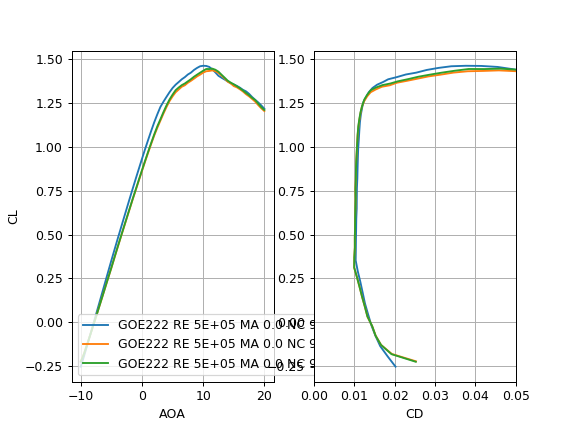

C:\Users\maxra\OneDrive\Python\Main\airfoilDesigner\af_analysis.py:47: RuntimeWarning: invalid value encountered in double_scalars
  [x,flag,_,_,_] = vf.iter(x,bl,p,s,None,None,vd)
C:\Users\maxra\OneDrive\Python\Main\airfoilDesigner\af_analysis.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  [x,flag,_,_,_] = vf.iter(x,bl,p,s,None,None,vd)


In [3]:
RENUMS = widgets.Text(
    value = '[5E5, 1E6]',
    placeholder='Type something',
    description='',
    disabled=False
)

# Mach values
MAV = widgets.FloatSlider(value = 0.0, min=0, max=.6, step=0.01, 
                          continuous_update=False,description='Mach')

# NCrit values
NCV = widgets.FloatSlider(value = 9.0, min=5, max=15, step=0.01, 
                            continuous_update=False,description='Ncrit',
                            readout_format='.1f')

# ANgles of Attack
AOAV = widgets.FloatRangeSlider(
    value=[-10, 20],
    min=-20,
    max=30.0,
    step=0.5,
    description='AOA',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

# Gurney Flap height
style = {'description_width': 'initial'}
GFV = widgets.FloatSlider(value = 0.0, min=0.0, max=4, step=0.25, 
                          continuous_update=False,description='Flap Height %c',style=style)

pol = []
axp = []
#(_,axp) = plt.subplots(1,2)

def clear_pol(b):
    global pol,axp
    pol = []
    plot_polar([])
    DOWNPOLAR.disabled = True

def run_calculation(b):
    # Calculate a polar
    # You can modify the loop to include NCRIT and Mach, but stay low with the Mach number.
    
    b.description = ''
    b.button_style = 'warning'
    b.icon='hourglass-half'
    global pol, AirfoilName
    REV = eval(RENUMS.value)
    if not type(REV) == list:
        REV=[REV]
    
    MACH = MAV.value
    NCRIT = NCV.value
    GFH = GFV.value*1.0/100.0
    
    AOAR = AOAV.value
    
    for RE in REV:
        (alv,clv,cdv,cmv,bl,p) = viiflowPolar(X,np.arange(AOAR[0],AOAR[1]+AOAV.step,AOAV.step),RE,NCRIT,MACH,GFH)
        pol.append({'AOA':alv,'CL':clv,'CD':cdv,'CM':cmv,'RE':RE,'NCRIT':NCRIT,'MA':MACH,'NAME':AirfoilName})
    
    b.description = 'Run'
    b.button_style = 'info'
    b.icon='play'
    
    DOWNPOLAR.disabled = False


def plot_polar(b):
    # Plot the polar
    global pol,axp
    
    if len(axp)==0:
        (_,axp) = plt.subplots(1,2)
    
    
    axp[0].clear()
    axp[1].clear()
    if len(pol)==0: return
    
    for k in range(len(pol)):
        axp[0].plot(pol[k]['AOA'],pol[k]['CL'],'-',label='%s RE %.E MA %1.1f NC %.1f'%(pol[k]['NAME'],pol[k]['RE'],pol[k]['MA'],pol[k]['NCRIT']))
        axp[1].plot(pol[k]['CD'],pol[k]['CL'],'-')
    axp[0].legend()
    axp[1].set_xlim(0,.05)
    axp[0].grid(1)
    axp[1].grid(1)
    axp[0].set_xlabel('AOA')
    axp[0].set_ylabel('CL')
    axp[1].set_xlabel('CD');
    
# Extra buttons

     
def download_polar(b):
    jsopenPolar = """
    <script type="text/Javascript">
        window.open("Polar.csv");
    </script>
    """
    
    
    global pol, AirfoilName
    # Save Polar data, if you want
    f = open('Polar.csv','w')
    f.close()
    f = open('Polar.csv','a')
    for k in range(len(pol)):
        # Header
        header = "%s - RE %.E - NCRIT %g - MA %g;;;\nAOA; CL; CD; CM"%\
                (pol[k]['NAME'],pol[k]['RE'],pol[k]['NCRIT'],pol[k]['MA'])
        X = np.c_[pol[k]['AOA'],pol[k]['CL'],pol[k]['CD'],pol[k]['CM']]
        np.savetxt(f, X, fmt='%1.8f; %1.8f; %1.8f; %1.8f', newline='\n', header=header,comments='')
    f.close()
    display(ipydisp.HTML(jsopenPolar));

DOWNPOLAR = widgets.Button(
    description='Download Polar',
    disabled=True,
    button_style='', # 'success', 'info', 'warning', 'danger' or '',
    icon='download'
)
DOWNPOLAR.on_click(download_polar)

RUN = widgets.Button(
    description='Run',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or '',
    icon='play'
)
RUN.on_click(run_calculation)

CLEAR = widgets.Button(
    description='Clear',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or '',
    icon='trash'
)
CLEAR.on_click(clear_pol)

PLOT = widgets.Button(
    description='Plot',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or '',
    icon='bar-chart'
)
PLOT.on_click(plot_polar)

display(widgets.VBox(
    [widgets.HBox([widgets.Label(value="Reynolds Numbers:"), RENUMS]),
     widgets.HBox([MAV,NCV]),widgets.HBox([AOAV,GFV])]))

UIRUN = widgets.HBox([RUN,PLOT,DOWNPOLAR,CLEAR])
display(UIRUN)

jsEmpty = """
    <script type="text/Javascript">
    </script>
    """